In [1]:
import jax 
import numpy as np
from jaxmapp.env import InstanceGeneratorCircleObs, InstanceGeneratorImageInput
from jaxmapp.roadmap import RandomSampler
from jaxmapp.planner import PrioritizedPlanning
from jaxmapp.utils import viz
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(46)

## multiple agents
generator = InstanceGeneratorCircleObs(num_agents_min=4, num_agents_max=4, 
                                                max_speeds_cands=[0.25], rads_cands=[0.05],
                                               map_size=160, num_obs=10)
ins_1 = generator.generate(key)
random_sampler = RandomSampler(share_roadmap=True, num_samples=100, max_T=64)
trms_random_1 = random_sampler.construct_trms(key, ins_1)
planner = PrioritizedPlanning(verbose=0)
res_random_1 = planner.solve(ins_1.to_numpy(), trms_random_1)


2022-02-07 20:49:53.156391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
## Single agent w/ many obstacles
generator = InstanceGeneratorCircleObs(num_agents_min=1, num_agents_max=1, 
                                                max_speeds_cands=[0.25], rads_cands=[0.05],
                                               map_size=160, num_obs=30)
ins_2 = generator.generate(key)
random_sampler = RandomSampler(share_roadmap=True, num_samples=100, max_T=64)
trms_random_2 = random_sampler.construct_trms(key, ins_2)
planner = PrioritizedPlanning(verbose=0)
res_random_2 = planner.solve(ins_2.to_numpy(), trms_random_2)


In [3]:
## Heterogeneous agents
generator = InstanceGeneratorCircleObs(num_agents_min=6, num_agents_max=6, 
                                                max_speeds_cands=[0.25, 0.5], rads_cands=[0.025, 0.05, 0.1],
                                               map_size=160, num_obs=10)

ins_3 = generator.generate(key)
random_sampler = RandomSampler(share_roadmap=False, num_samples=100, max_T=64)
trms_random_3 = random_sampler.construct_trms(key, ins_3)
planner = PrioritizedPlanning(verbose=0)
res_random_3 = planner.solve(ins_3.to_numpy(), trms_random_3)


In [4]:
# image input
image = np.zeros((160, 160))
image[20:30, 30:60] = 1
image[20:30, 110:140] = 1
image[120:130, 30:60] = 1
image[70:80, 60:110] = 1
image[120:130, 110:140] = 1
image[20:130, 130:140] = 1

generator = InstanceGeneratorImageInput(num_agents_min=6, num_agents_max=6, 
                                                max_speeds_cands=[0.25], rads_cands=[0.05],
                                                image=image)
ins_4 = generator.generate(key)
random_sampler = RandomSampler(share_roadmap=True, num_samples=100, max_T=64)
trms_random_4 = random_sampler.construct_trms(key, ins_4)
planner = PrioritizedPlanning(verbose=0)
res_random_4 = planner.solve(ins_4.to_numpy(), trms_random_4)


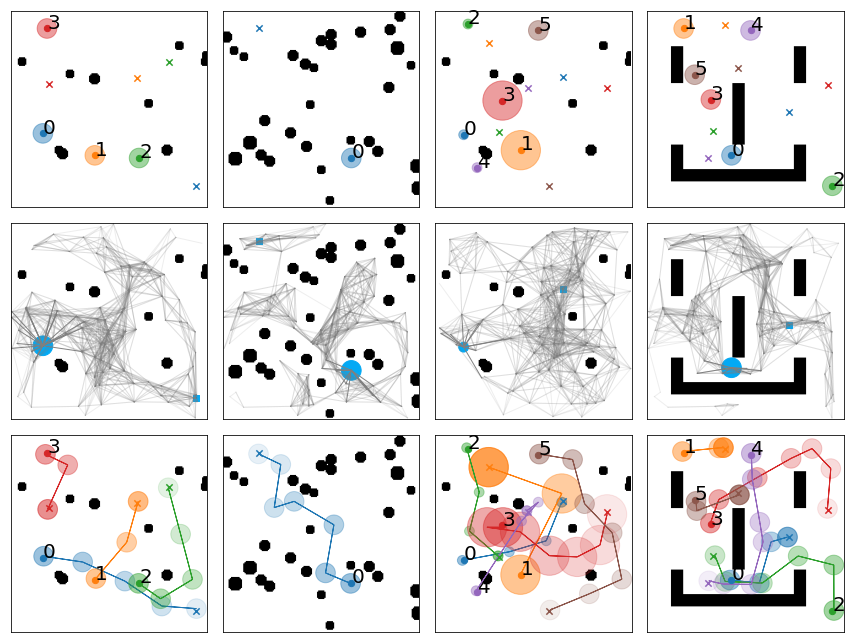

In [5]:

fig, axes = plt.subplots(3, 4, figsize=[12, 9])
viz.simple_plot_2d(ins_1, ax=axes[0, 0])
viz.plot_trms(ins_1, trms_random_1, ax=axes[1, 0])
viz.simple_plot_2d(ins_1, res_random_1, ax=axes[2, 0])

viz.simple_plot_2d(ins_2, ax=axes[0, 1])
viz.plot_trms(ins_2, trms_random_2, ax=axes[1, 1])
viz.simple_plot_2d(ins_2, res_random_2, ax=axes[2, 1])

viz.simple_plot_2d(ins_3, ax=axes[0, 2])
viz.plot_trms(ins_3, trms_random_3, ax=axes[1, 2])
viz.simple_plot_2d(ins_3, res_random_3, ax=axes[2, 2])

viz.simple_plot_2d(ins_4, ax=axes[0, 3])
viz.plot_trms(ins_4, trms_random_4, ax=axes[1, 3])
viz.simple_plot_2d(ins_4, res_random_4, ax=axes[2, 3])
plt.tight_layout()
plt.savefig("figures/gallery.png")

res_grid=Status: solved, makespan: 35.00, sum-of-costs: 262.00, sum-of-costs (normed): 26.20
res_random=Status: solved, makespan: 39.00, sum-of-costs: 252.00, sum-of-costs (normed): 25.20
res_ctrm=Status: solved, makespan: 31.00, sum-of-costs: 213.00, sum-of-costs (normed): 21.30


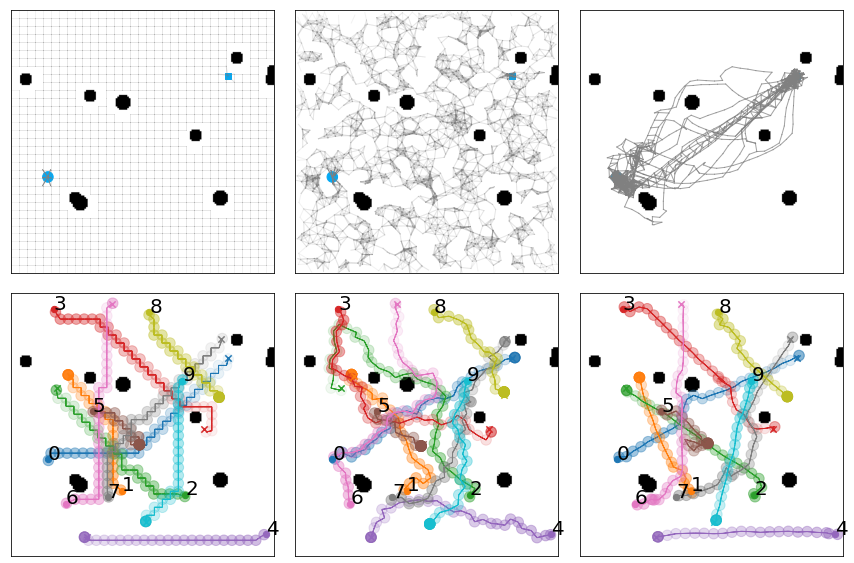

In [6]:
# for creating 
import jax 
import numpy as np
from jaxmapp.env import InstanceGeneratorCircleObs
from jaxmapp.roadmap import GridSampler, RandomSampler, load_pretrained_ctrm_sampler
from jaxmapp.planner import PrioritizedPlanning
from jaxmapp.utils import viz
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(46)

# instance generation
generator = InstanceGeneratorCircleObs(num_agents_min=10, num_agents_max=10, 
                                        max_speeds_cands=[0.04], rads_cands=[0.02],
                                        map_size=160, num_obs=10)
ins = generator.generate(key)

# Grid sampling
grid_sampler = GridSampler(share_roadmap=True, num_samples=1200, max_T=64)
trms_grid = grid_sampler.construct_trms(key, ins)

# Random sampling
random_sampler = RandomSampler(share_roadmap=True, num_samples=1600, max_T=64)
trms_random = random_sampler.construct_trms(key, ins)

# CTRM; it requires to load pretrained model weights
ctrm_sampler = load_pretrained_ctrm_sampler(model_yaml="../scripts/config/model/ctrm.yaml",
                                           model_dir="../model/training_hetero_k05",
                                           sampler_yaml="../scripts/config/sampler/ctrm.yaml", 
                                           sampler_args={"num_samples":15})
trms_ctrm = ctrm_sampler.construct_trms(key, ins)

planner = PrioritizedPlanning(verbose=0)
res_grid = planner.solve(ins.to_numpy(), trms_grid)
res_random = planner.solve(ins.to_numpy(), trms_random)
res_ctrm = planner.solve(ins.to_numpy(), trms_ctrm)
print(f"{res_grid=}")
print(f"{res_random=}")
print(f"{res_ctrm=}")

fig, axes = plt.subplots(2, 3, figsize=[12, 8])
viz.plot_trms(ins, trms_grid, ax=axes[0, 0])
viz.plot_trms(ins, trms_random, ax=axes[0, 1])
viz.plot_trms(ins, trms_ctrm, is_timed=True, ax=axes[0, 2])
viz.simple_plot_2d(ins, res_grid, ax=axes[1, 0])
viz.simple_plot_2d(ins, res_random, ax=axes[1, 1])
viz.simple_plot_2d(ins, res_ctrm, ax=axes[1, 2])

plt.tight_layout()
plt.savefig("figures/roadmap.png")

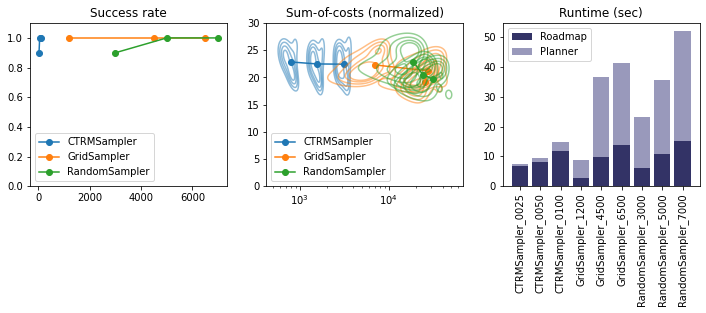

In [7]:
from jaxmapp.utils.viz import visualize_evaluation_results
import matplotlib.pyplot as plt

dirname = "../data_example/eval_data/example"  # change this to "/workspace" if you are in the docker container

visualize_evaluation_results(dirname);

plt.savefig("figures/benchmark.png")